# How to Run Inference on YOLOv7 with Native Pytorch and OpenVINO™ Torch-ORT

This tutorial is based on the [YOLOv7 repository](https://github.com/WongKinYiu/yolov7) by WongKinYiu. This notebook shows evaluation on **your own custom objects**. Many thanks to WongKinYiu and AlexeyAB for putting this repository together. 

### **Accompanying Blog Post**

We recommend that you follow along in this notebook while reading the blog post: [Accelerate PyTorch Models via OpenVINO™ Integration with Torch-ORT](https://blog.roboflow.com/accelerate-pytorch-openvino-torch-ort/)
<br>



### **Custom Dataset**

Follow [the getting started guide here](https://docs.roboflow.com/quick-start) to create and prepare your own custom dataset.


If you already have your own images (and, optionally, annotations), you can convert your dataset using [Roboflow](https://roboflow.com), a set of tools developers use to build better computer vision models quickly and accurately. 100k+ developers use roboflow for (automatic) annotation, converting dataset formats (like to YOLOv7), training, deploying, and improving their datasets/models.


### **Steps Covered in this Tutorial**

To run the inference on a test image we take the following steps:

* Evaluate YOLOv7 performance with Native Pytorch
* Evaluate YOLOv7 performance with OpenVINO™ integration with Torch-ORT

OPTIONAL:
* Reparameterize for Inference 
* Deployment
* Active Learning

#Install Dependencies

_(Remember to choose None in Runtime if not already selected. Runtime --> Change Runtime Type --> Hardware accelerator --> None)_

Reminder, uploaded files will get deleted when this runtime is recycled.

In [1]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

In [1]:
# Download YOLOv7 repository from Roboflow-ai and install requirements
!git clone https://github.com/roboflow-ai/yolov7.git
%cd yolov7
!pip install -r requirements.txt

fatal: destination path 'yolov7' already exists and is not an empty directory.
/content/yolov7
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install torch==1.12.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Correctly Formatted Custom Data

Next, we'll download our dataset in the right format. Use the `YOLOv7 PyTorch` export. Note that this model requires YOLO TXT annotations, a custom YAML file, and organized directories. The roboflow export writes this for us and saves it in the correct spot.

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="7V4JO5rw8XDPaod54Qdc")
project = rf.workspace("a-s").project("uwh")
dataset = project.version(6).download("yolov7")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to UWH-6 in yolov7pytorch:: 100%|██████████| 1874/1874 [00:01<00:00, 1400.39it/s]


In [4]:
!ls /content/yolov7

cfg	       detect_without_jit.py  LICENSE.md	runs	      train.py
data	       export.py	      models		scripts       utils
deploy	       figure		      paper		test.py       UWH-6
detect_ort.py  hubconf.py	      README.md		tools
detect.py      inference	      requirements.txt	train_aux.py


# Evaluation

We can evaluate the performance of our custom training using the provided evalution script.

# Evaluate YOLOv7 performance with Native Pytorch

Note we can adjust the below custom arguments. For details, see [the arguments accepted by detect.py](https://github.com/WongKinYiu/yolov7/blob/main/detect.py#L154).

There are 2 minor changes we've made to run "detect.py" on CPU:
1.  We have commented out lines 38 and 39 in detect.py as the code is using [jit trace](https://pytorch.org/docs/stable/generated/torch.jit.trace.html).
2. Added lines 84 and 85 to enable device type as "cpu"

In [5]:
# If you DO NOT have a retrained model, use this command to run evaluation with the provided trained model: 

!python detect_without_jit.py --weights /content/yolov7/runs/best.pt --conf 0.25 --img-size 640 --source UWH-6/test/images/DJI_0021_mp4-32_jpg.rf.0d9b746d8896d042b55a14c8303b4f36.jpg

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='UWH-6/test/images/DJI_0021_mp4-32_jpg.rf.0d9b746d8896d042b55a14c8303b4f36.jpg', update=False, view_img=False, weights=['/content/yolov7/runs/best.pt'])
YOLOR 🚀 1582cec torch 1.12.1+cu113 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36514136 parameters, 6194944 gradients, 103.3 GFLOPS
4 black-hats, 9 bodysurfaces, Done. (1551.2ms) Inference, (21.6ms) N

Refer to "Display Inference on test image" section to display the saved image.

# Display inference on test image

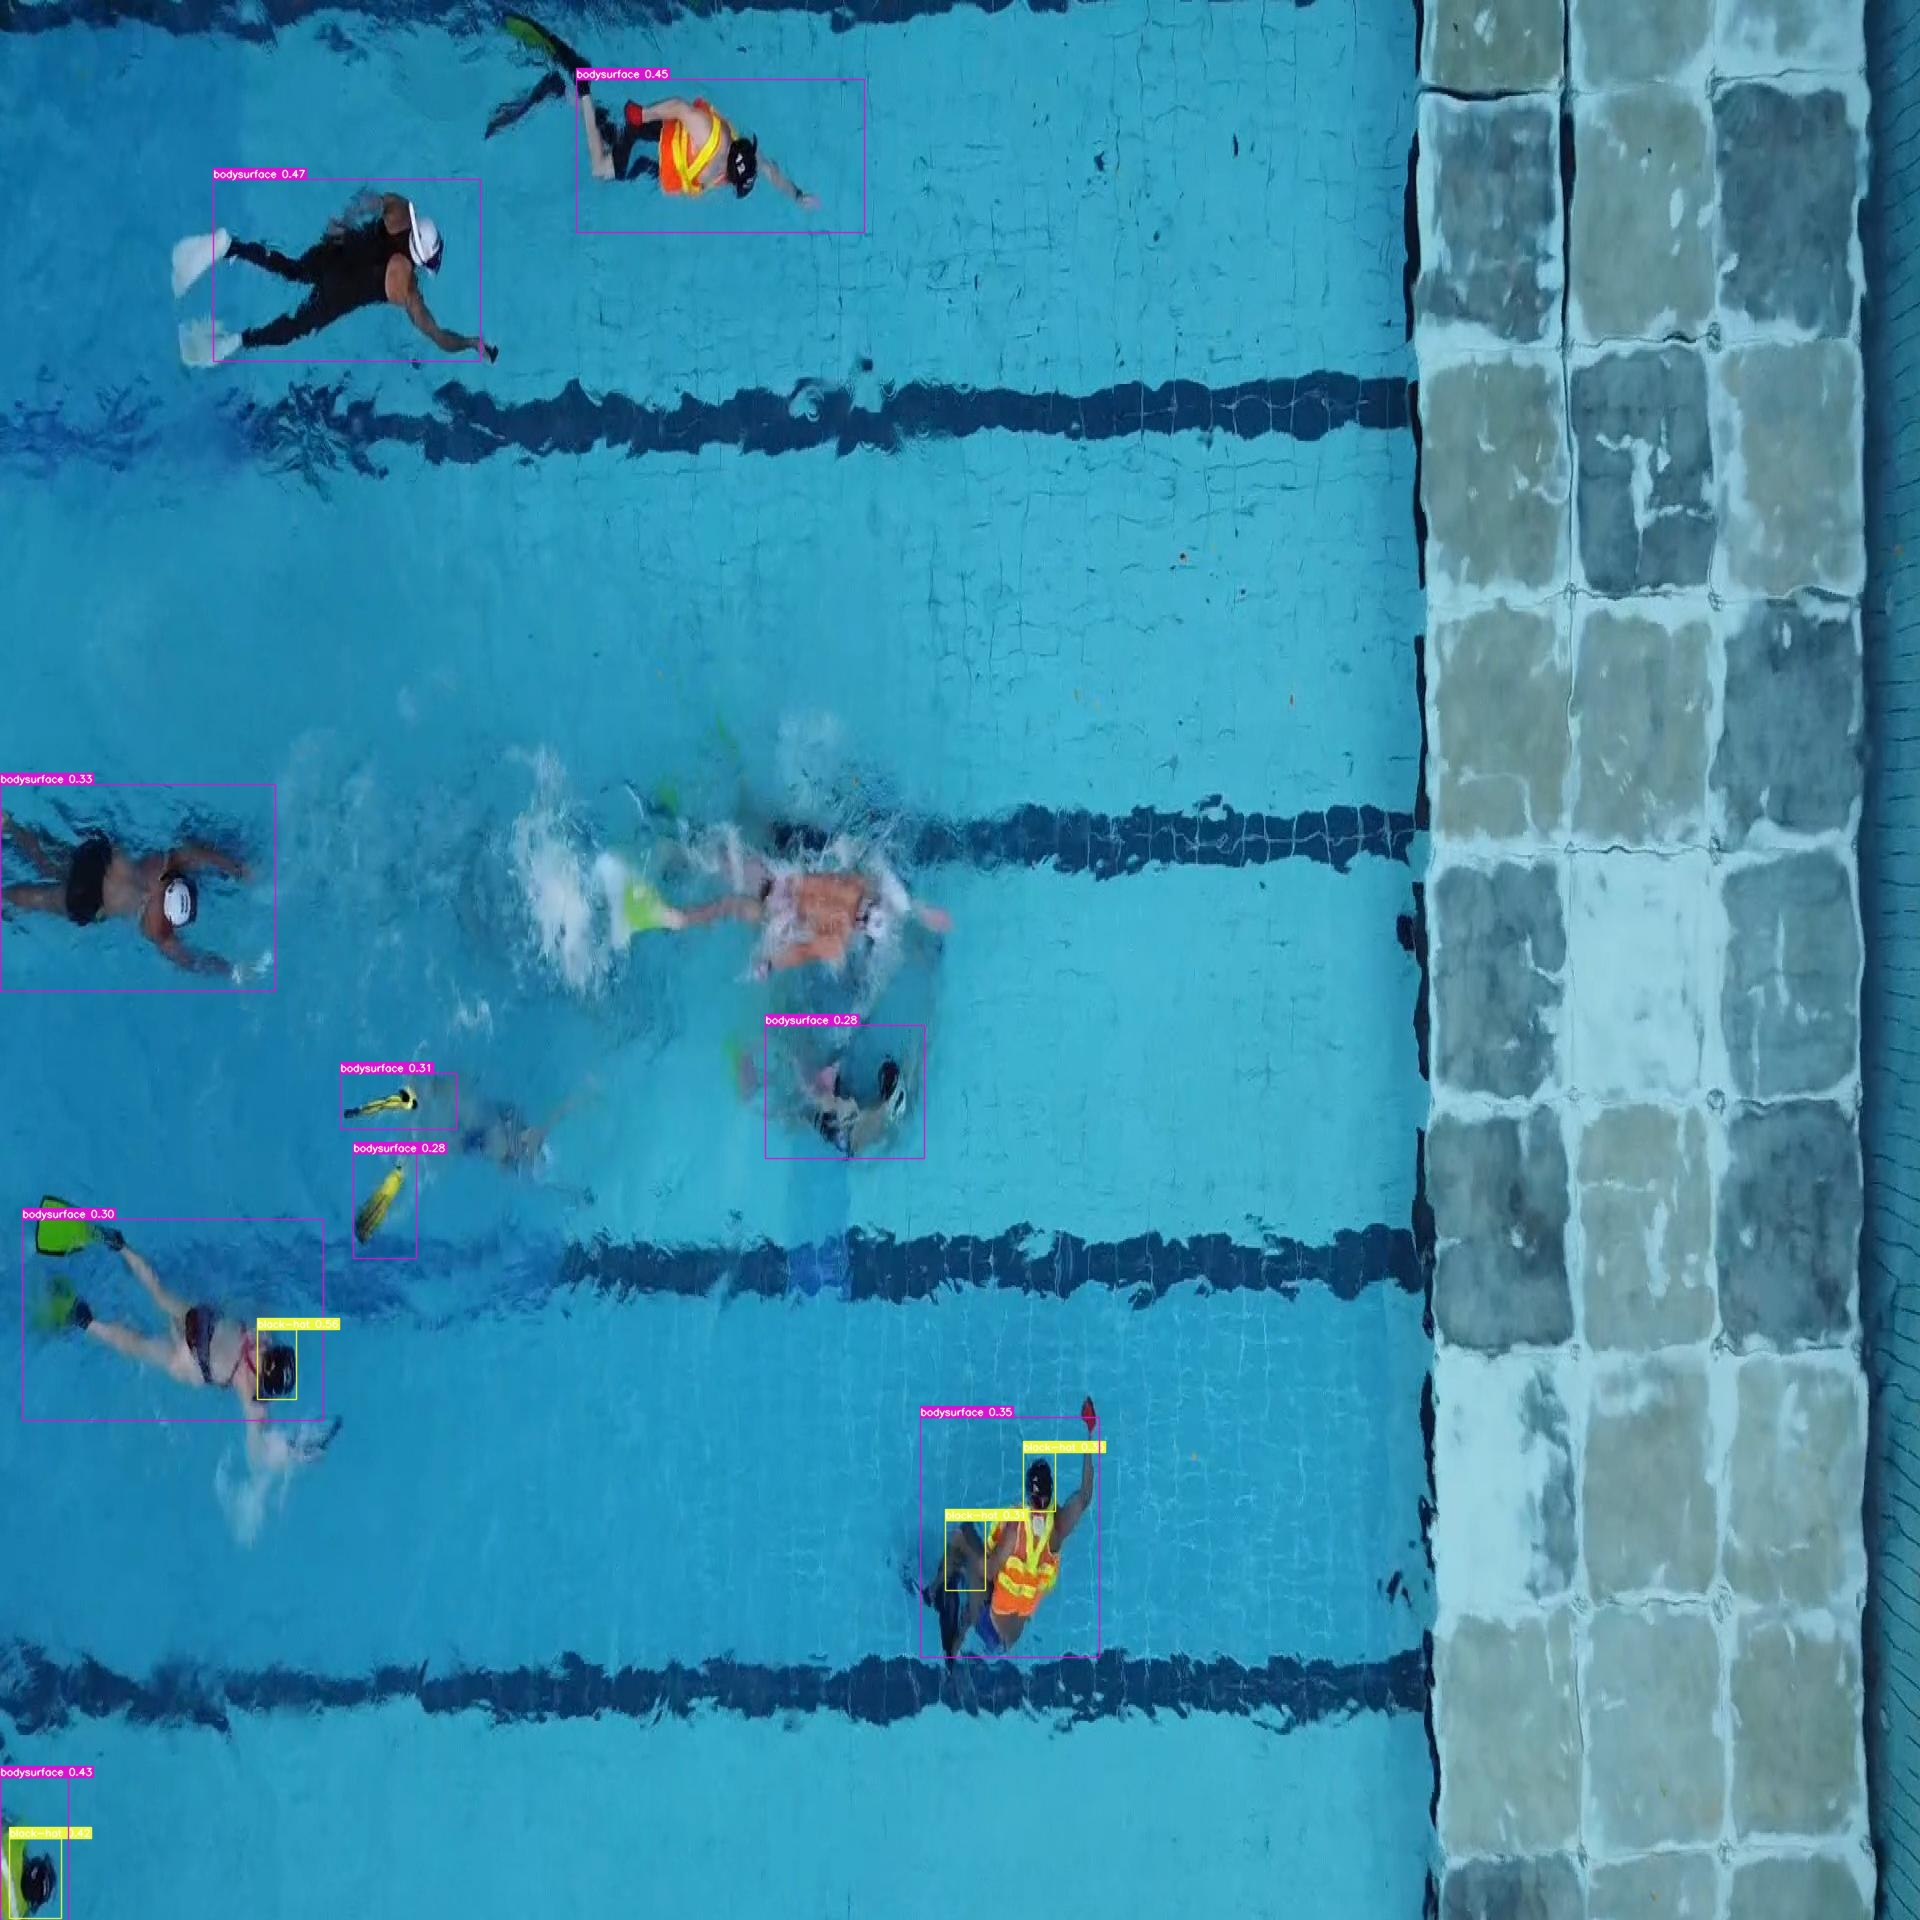

In [6]:
#display inference on a sample image

import glob
from IPython.display import Image, display

i = 0
limit = 10000 # max images to print
# Change the path below according to the location where result image is saved.
for imageName in glob.glob('/content/yolov7/runs/detect/exp/*.jpg'): #assuming JPG. 
    if i < limit:
      display(Image(filename=imageName))
      print("\n")
    i = i + 1

# Evaluate YOLOv7 performance with OpenVINO™ integration with Torch-ORT

In [7]:
# Install torch-ort-infer 
!pip install torch-ort-infer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41.8 MB 111 kB/s 
     |████████████████████████████████| 13.1 MB 43.2 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for cerberus: filename=Cerberus-1.3.4-py3-none-any.whl size=58195 sha256=ba7072d5cfc627954ba7686b147ad23d763f86b2d7cf074ce8d978ab0433ba25
  Stored in directory: /root/.cache/pip/wheels/6c/bd/4b/a3b7dcd0bc718e601a9ba7cba5f7c1d73fd777b6dc48d6eaa0
Successfully built cerberus


In [8]:
!python -m torch_ort.configure

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
running build
running build_ext
/usr/local/lib/python3.7/dist-packages/torch/utils/cpp_extension.py:411: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
building 'torch_interop_utils' extension
creating build
creating build/temp.linux-x86_64-3.7
creating build/temp.linux-x86_64-3.7/usr
creating build/temp.linux-x86_64-3.7/usr/local
creating build/temp.linux-x86_64-3.7/usr/local/lib
creating build/temp.linux-x86_64-3.7/usr/local/lib/python3.7
creating build/temp.linux-x86_64-3.7/usr/local/lib/python3.7/dist-packages
creating build/temp.linux-x86_64-3.7/usr/local/lib/python3.7/dist-packages/onnxruntime
creating build/temp.linux-x86_64-3.7/usr/local/lib/python3.7/dist-packages/onnxruntime/training
creating build/temp.li

Note we can adjust the below custom arguments. For details, see [the arguments accepted by detect.py](https://github.com/WongKinYiu/yolov7/blob/main/detect.py#L154).

Here, we added just 2 lines of code to boost performance with OpenVINO™ Torch-ORT

  line 17: from torch_ort import ORTInferenceModule

  line 71: model = ORTModule(model)   

In [9]:
# If you DO NOT have a retrained model, use this command to run evaluation using the provided trained model: 
!python detect_ort.py --weights /content/yolov7/runs/best.pt --conf 0.25 --img-size 640 --source UWH-6/test/images/DJI_0021_mp4-32_jpg.rf.0d9b746d8896d042b55a14c8303b4f36.jpg

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='UWH-6/test/images/DJI_0021_mp4-32_jpg.rf.0d9b746d8896d042b55a14c8303b4f36.jpg', update=False, view_img=False, weights=['/content/yolov7/runs/best.pt'])
YOLOR 🚀 1582cec torch 1.12.1+cu113 CPU

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
IDetect.fuse
/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Model Summary: 314 layers, 36514136 parameters, 6194944 gradients, 103.3 GFLOPS
/usr/loc

# Display inference on test image

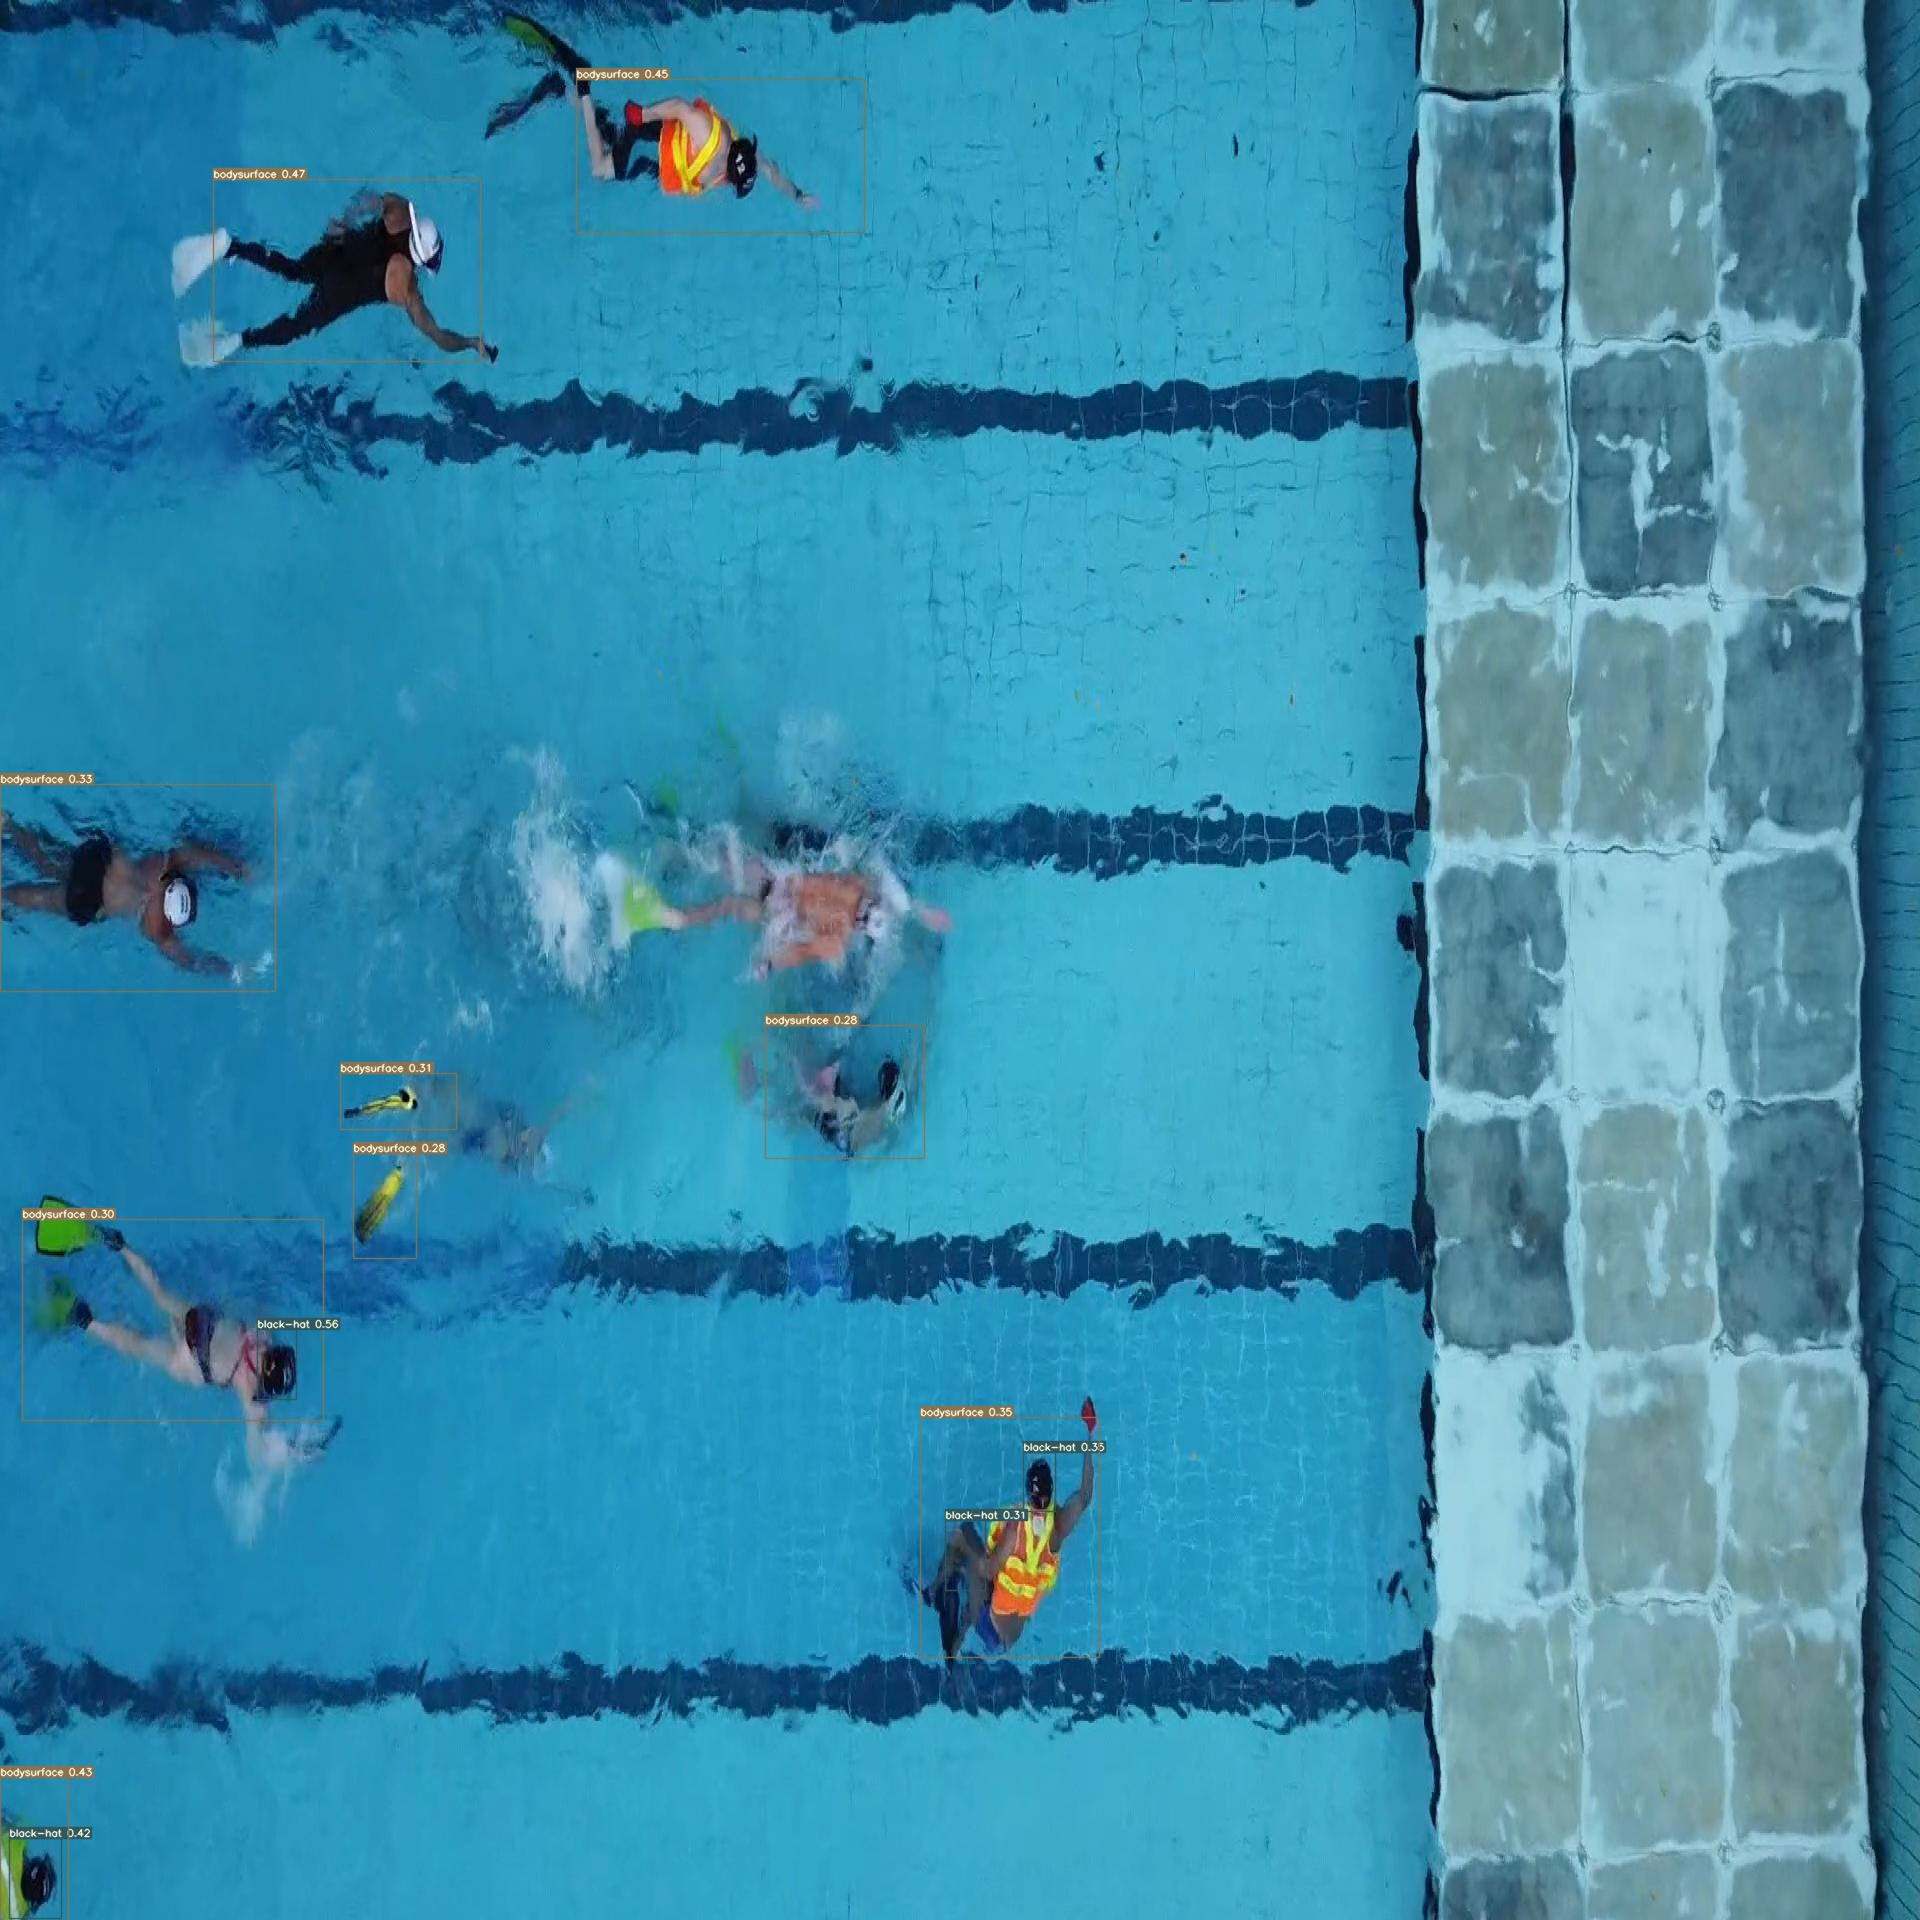

In [10]:
#display inference on sample image

import glob
from IPython.display import Image, display

i = 0
limit = 10000 # max images to print
for imageName in glob.glob('/content/yolov7/runs/detect/exp2/*.jpg'): #assuming JPG
    if i < limit:
      display(Image(filename=imageName))
      print("\n")
    i = i + 1

# Compare the time difference with Stock PyTorch and with OpenVINO Integration with Torch ORT.(Lower the better)



**Stock PT:** INFERENCE TIME WITH NATIVE PYTORCH IS **1214.8 ms**  


**OVTORT:** INFERENCE TIME WITH OPENVINO™ INTEGRATION WITH TORCH-ORT IS **908.0 ms**